In [53]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [54]:
df = pd.read_csv('./../../error_dfs/error_2019_may2021_VAR.csv', converters={'ags2': str, 'ags5': str} )

In [55]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [56]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['error'] = df['ground_truth'] - df['pred']
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
0,2018-12-01,7.3,7.566702,01001,01,Schleswig-Holstein,"Flensburg, Stadt",-0.266702
1,2019-01-01,8.2,8.038843,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.161157
2,2019-02-01,7.8,8.022765,01001,01,Schleswig-Holstein,"Flensburg, Stadt",-0.222765
3,2019-03-01,7.8,7.754631,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.045369
4,2019-04-01,7.6,7.502805,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.097195
...,...,...,...,...,...,...,...,...
12025,2021-01-01,7.3,7.479328,16077,16,Thüringen,Altenburger Land,-0.179328
12026,2021-02-01,7.3,7.435923,16077,16,Thüringen,Altenburger Land,-0.135923
12027,2021-03-01,7.2,7.046545,16077,16,Thüringen,Altenburger Land,0.153455
12028,2021-04-01,6.9,6.780956,16077,16,Thüringen,Altenburger Land,0.119044


In [57]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

## Plot each variable

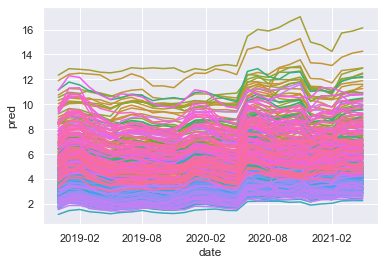

In [58]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

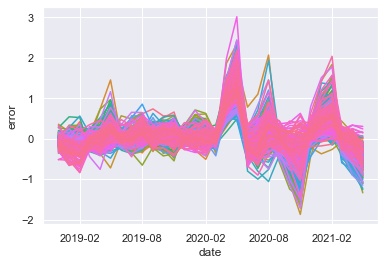

In [59]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

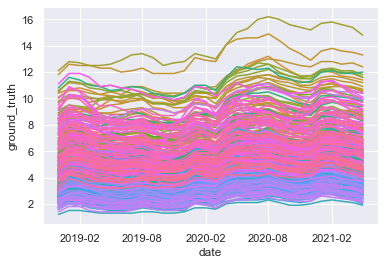

In [60]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

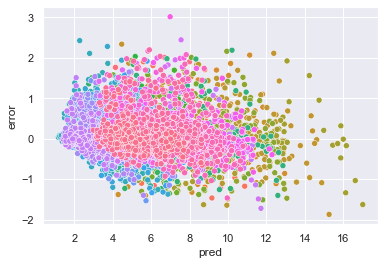

In [61]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [62]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [63]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [64]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

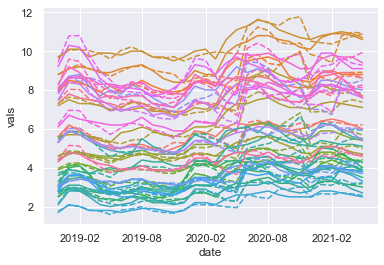

In [65]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into mean errors

In [66]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.580000,8.347893,0.232107
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",8.110000,8.065461,0.044539
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.870000,7.729069,0.140931
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.566667,8.385199,0.181468
01051,01,Schleswig-Holstein,Dithmarschen,5.926667,5.888471,0.038196
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.676667,5.628680,0.047987
16074,16,Thüringen,Saale-Holzland-Kreis,4.430000,4.351722,0.078278
16075,16,Thüringen,Saale-Orla-Kreis,4.820000,4.763045,0.056955


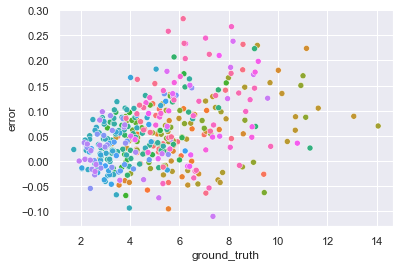

In [67]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

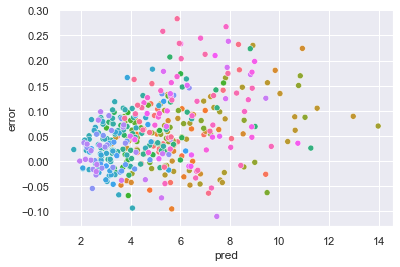

In [68]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [69]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
16068,16,Thüringen,Sömmerda,6.156667,5.873520,0.283147
15001,15,Sachsen-Anhalt,Dessau-Roßlau,8.113333,7.846026,0.267307
16054,16,Thüringen,Suhl,5.553333,5.295108,0.258225
14713,14,Sachsen,Leipzig,7.063333,6.818831,0.244503
12053,12,Brandenburg,Frankfurt (Oder),8.176667,7.938301,0.238366
...,...,...,...,...,...,...
06632,06,Hessen,Hersfeld-Rotenburg,3.833333,3.901983,-0.068650
10045,10,Saarland,Saarpfalz-Kreis,5.170000,5.243243,-0.073243
09172,09,Freistaat Bayern,Berchtesgadener Land,3.976667,4.070157,-0.093490


<AxesSubplot:xlabel='error', ylabel='Density'>

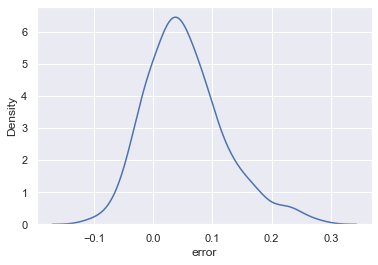

In [70]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [71]:
df.sort_values(by = ['error'], ascending=False)

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
10427,2020-05-01,10.0,6.987730,13073,13,Mecklenburg-Vorpommern,Vorpommern-Rügen,3.012270
9737,2020-05-01,10.0,7.558756,11000,11,Berlin,Berlin,2.441244
7037,2020-05-01,4.7,2.277278,09180,09,Freistaat Bayern,Garmisch-Partenkirchen,2.422722
1817,2020-05-01,6.8,4.465216,03462,03,Niedersachsen,Wittmund,2.334784
7397,2020-05-01,6.0,3.721609,09262,09,Freistaat Bayern,Passau,2.278391
...,...,...,...,...,...,...,...,...
2723,2020-11-01,15.4,17.028100,05513,05,Nordrhein-Westfalen,Gelsenkirchen,-1.628100
2483,2020-11-01,7.1,8.731321,05358,05,Nordrhein-Westfalen,Düren,-1.631321
2153,2020-11-01,8.3,9.944231,05122,05,Nordrhein-Westfalen,Solingen,-1.644231
9563,2020-11-01,10.0,11.721493,10041,10,Saarland,Regionalverband Saarbrücken,-1.721493


In [72]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

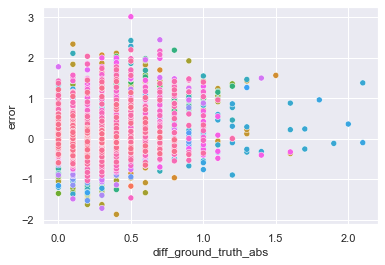

In [73]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

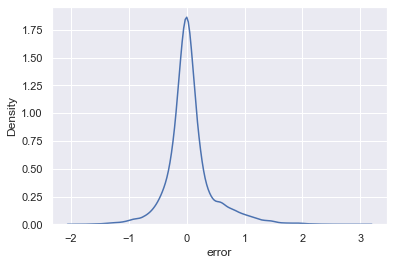

In [74]:
sns.kdeplot(data=df, x="error", common_norm=False)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='error', ylabel='Density'>

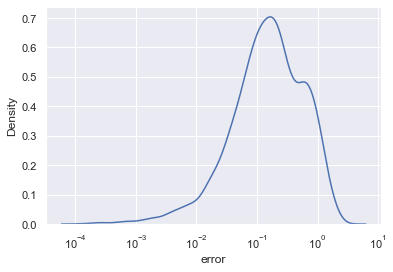

In [75]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [76]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df_structural = pd.merge(df_structural, df[['ags5','bundesland']])

### Merge to df with mean errors

In [77]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
df_mixed['bundesland'] = df_mixed['bundesland'].astype('category')
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [78]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    g = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    g.set_title('errors crisis & non-crisis VAR model')
    plt.savefig(f'{column_name}_errors_crisis.png')
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

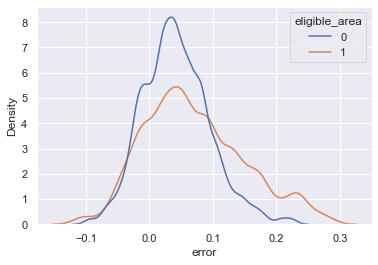

Ttest_indResult(statistic=-22.1888593198847, pvalue=5.019839426477714e-106)

In [79]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

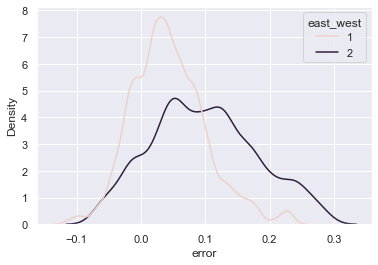

Ttest_indResult(statistic=30.437706466333154, pvalue=1.1234211099980949e-176)

In [80]:
compare_error_in_two_groups(df_mixed, 'east_west')

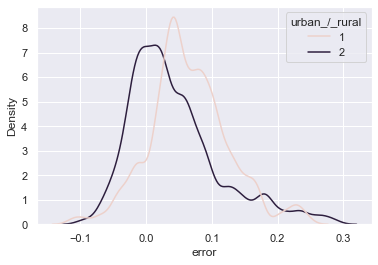

Ttest_indResult(statistic=-18.749307173892753, pvalue=2.5504988586119162e-77)

In [81]:
compare_error_in_two_groups(df_mixed, 'urban_/_rural')

### Compare compare error in multiple groups

In [82]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

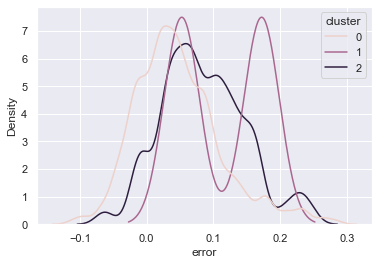

             sum_sq       df           F         PR(>F)
cluster    2.385032      1.0  561.698544  2.124923e-121
Residual  51.072176  12028.0         NaN            NaN


In [83]:
compare_error_in_two_groups(df_mixed, "cluster")

In [84]:
#compare_error_in_two_groups(df_mixed, "ags2")

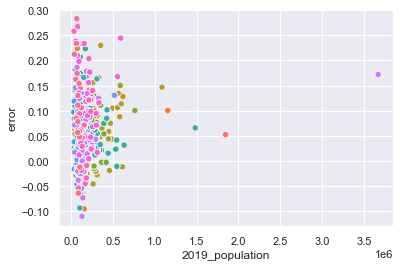

In [85]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

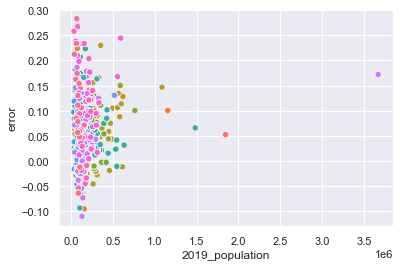

In [86]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [87]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [88]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_/_rural'] = df_mixed['urban_/_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = df_mixed['error']

X = pd.get_dummies(data=X, drop_first=True)

In [89]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [90]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min     1Q  Median     3Q    Max
-0.1112 -0.022  0.0011 0.0225 0.1638


Coefficients:
                                                   Estimate                  Std. Error            t value   p value
_intercept                                        -0.293417 -2.655260e+03-6.832075e+03j   0.00000-0.00000j  0.999968
supermarkets_population                           -0.000038 -3.863500e-02+1.039000e-03j   0.00100+0.00000j  0.999209
supermarkets_average_distance                      0.000011  1.903600e-02+1.645000e-03j   0.00060-0.00010j  0.999524
public_transport_availability                     -0.000515  6.073000e-03+3.840000e-04j  -0.08450+0.00530j  0.932550
average_distance_bus_stop                          0.000015  2.014900e-02-3.000000e-04j   0.00070+0.00000j  0.999408
average_distance_train_station                    -0.000005  1.549100e-02+2.581000e-03j  -0.00030+0.00010j  0.999739
average_distance_public_transport                 -0.000015  1.086420e-01+5.5150

### Sequential Feature Selector

In [91]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [92]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(23,)","[0.2901027653905264, 0.12994823750356999, -0.0...",0.144047,"(car_density,)",0.185929,0.144659,0.07233
2,"(23, 188)","[0.30688964964190046, 0.10940742967768857, 0.0...",0.170558,"(car_density, east_west_2)",0.191849,0.149265,0.074632
3,"(23, 152, 188)","[0.32854034320646763, 0.11591686981558713, 0.1...",0.193703,"(car_density, debtor_quota, east_west_2)",0.184639,0.143656,0.071828
4,"(23, 129, 152, 188)","[0.31557097114641697, 0.1532141458445515, 0.16...",0.209444,"(car_density, mixed_use_area_percentage, debto...",0.169278,0.131704,0.065852
5,"(23, 129, 152, 169, 188)","[0.3086650519028441, 0.17439537324242704, 0.19...",0.227515,"(car_density, mixed_use_area_percentage, debto...",0.167246,0.130123,0.065062
6,"(23, 129, 143, 152, 169, 188)","[0.2939163171839637, 0.1713299834294324, 0.214...",0.246562,"(car_density, mixed_use_area_percentage, swamp...",0.136791,0.106428,0.053214
7,"(23, 129, 139, 143, 152, 169, 188)","[0.27141761962605127, 0.20157972294324356, 0.2...",0.255693,"(car_density, mixed_use_area_percentage, forre...",0.116619,0.090733,0.045367
8,"(23, 129, 139, 143, 152, 153, 169, 188)","[0.27050931751701734, 0.20881751265081983, 0.2...",0.26471,"(car_density, mixed_use_area_percentage, forre...",0.108477,0.084399,0.0422
9,"(23, 129, 137, 139, 143, 152, 153, 169, 188)","[0.27605546182750684, 0.2221796633071278, 0.28...",0.275297,"(car_density, mixed_use_area_percentage, shipp...",0.110152,0.085702,0.042851
10,"(23, 129, 137, 139, 143, 152, 153, 169, 188, 191)","[0.2844039768912242, 0.23581613809119029, 0.27...",0.286309,"(car_density, mixed_use_area_percentage, shipp...",0.109912,0.085515,0.042757


In [93]:
list(summary_table_select['feature_names'])[:5]

[('car_density',),
 ('car_density', 'east_west_2'),
 ('car_density', 'debtor_quota', 'east_west_2'),
 ('car_density', 'mixed_use_area_percentage', 'debtor_quota', 'east_west_2'),
 ('car_density',
  'mixed_use_area_percentage',
  'debtor_quota',
  'border_proximity',
  'east_west_2')]

### Ridge

In [94]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

Ridge(alpha=0.5)

In [95]:
stats.summary(rr, X, Y, X.columns)

Residuals:
   Min      1Q  Median     3Q    Max
-0.116 -0.0224 -0.0004 0.0233 0.1559


Coefficients:
                                                  Estimate                  Std. Error           t value   p value
_intercept                                       -2.774323 -2.674736e+03-6.882176e+03j  0.00010-0.00040j  0.999700
supermarkets_population                          -0.000226  1.367630e-01+1.256550e-01j -0.00090+0.00080j  0.999028
supermarkets_average_distance                     0.000012  2.921900e-02+3.312700e-02j  0.00020-0.00020j  0.999778
public_transport_availability                    -0.000673  2.073000e-03-6.236000e-03j -0.03230-0.09720j  0.918407
average_distance_bus_stop                         0.000026  1.759900e-02+5.319000e-03j  0.00140-0.00040j  0.998855
average_distance_train_station                   -0.000006  2.035600e-02-7.040000e-04j -0.00030-0.00000j  0.999750
average_distance_public_transport                -0.000027  4.025800e-02+4.770000e-03j -0.0007

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

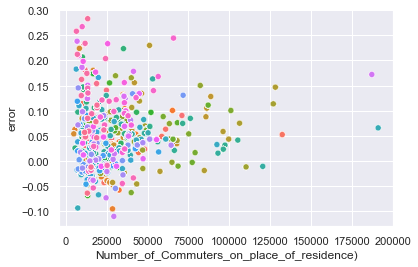

In [96]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.legend_.remove()

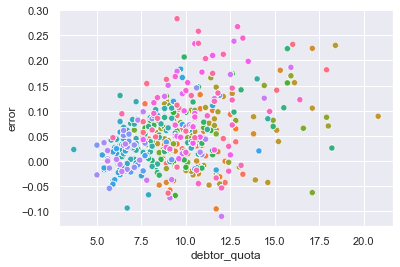

In [97]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('errors crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('debtor_quota.png')

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

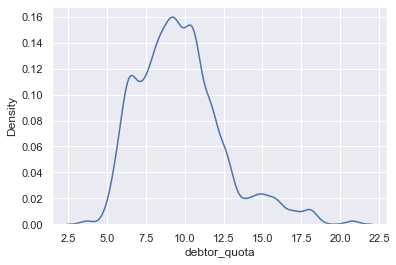

In [98]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

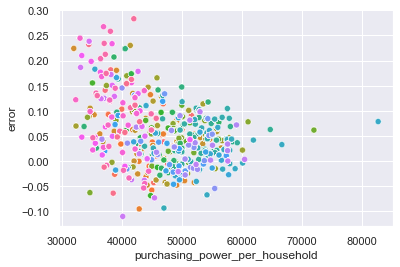

In [99]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('errors crisis & non-crisis VAR model')
g.legend_.remove()
plt.savefig('purchasing_power_per_household.png')

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

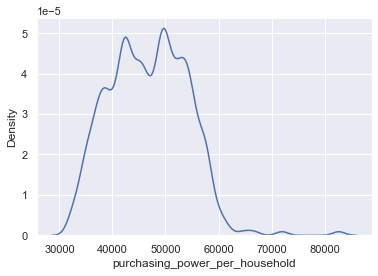

In [100]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

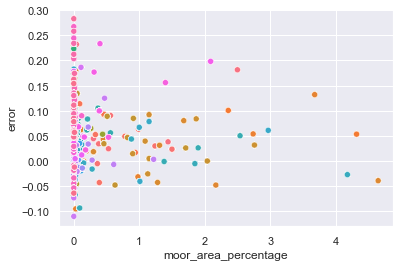

In [101]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()